In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2

In [70]:
# Carregar e normalizar o dataset MNIST
def load_and_prepare_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    return (x_train, y_train), (x_test, y_test)

In [71]:
# Adicionar um parâmetro para o número de camadas densas
def create_model(units, activation, dropout_rate, regularizer, optimizer, loss, num_dense_layers=1):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    
    # Adicionar múltiplas camadas densas com base no parâmetro num_dense_layers
    for _ in range(num_dense_layers):
        model.add(Dense(units=units, activation=activation, use_bias=True,
                        kernel_initializer="glorot_uniform", bias_initializer="zeros",
                        kernel_regularizer=regularizer))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model


In [72]:
# Modificar a função de treinamento para aceitar o novo parâmetro
def train_and_evaluate_model(x_train, y_train, x_test, y_test, units, activation, dropout_rate, regularizer, optimizer_class, loss, num_dense_layers=1):
    if optimizer_class == Adam:
        optimizer = optimizer_class(learning_rate=0.0005)
    else:
        optimizer = optimizer_class()
    
    model = create_model(units, activation, dropout_rate, regularizer, optimizer, loss, num_dense_layers)
    
    if isinstance(loss, CategoricalCrossentropy):
        y_train_cat = tf.keras.utils.to_categorical(y_train)
        y_test_cat = tf.keras.utils.to_categorical(y_test)
        history = model.fit(x_train, y_train_cat, epochs=5, batch_size=128, validation_split=0.2, verbose=0)
        test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    else:
        history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2, verbose=0)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    
    return test_acc, history.history['val_accuracy'][-1]

In [73]:
# Função para executar experimentos para um otimizador específico
def run_experiments_for_optimizer(optimizer_class, units_list, activations_list, dropout_rates, regularizers, num_dense_layers_list, losses):
    (x_train, y_train), (x_test, y_test) = load_and_prepare_data()
    results = []

    for units in units_list:
        for activation in activations_list:
            for dropout_rate in dropout_rates:
                for regularizer in regularizers:
                    for num_dense_layers in num_dense_layers_list:  # Adicione este loop
                        for loss in losses:
                            test_acc, val_acc = train_and_evaluate_model(
                                x_train, y_train, x_test, y_test,
                                units, activation, dropout_rate, regularizer,
                                optimizer_class, loss, num_dense_layers  # Passe o parâmetro aqui
                            )
                            results.append({
                                'Units': units,
                                'Activation': activation,
                                'Dropout': dropout_rate,
                                'Regularizer': regularizer,
                                'Num Dense Layers': num_dense_layers,  # Adicione este campo para registrar o número de camadas
                                'Optimizer': optimizer_class.__name__,
                                'Loss': loss.__class__.__name__,
                                'Test Accuracy': test_acc,
                                'Validation Accuracy': val_acc
                            })

    return pd.DataFrame(results)

In [74]:

# Função para plotar os resultados
def plot_results(results_df, optimizer_name):
    plt.figure(figsize=(10, 6))
    plt.title(f'Results for Optimizer: {optimizer_name}')
    plt.plot(results_df['Test Accuracy'], label='Test Accuracy', marker='o')
    plt.plot(results_df['Validation Accuracy'], label='Validation Accuracy', marker='x')
    plt.xlabel('Experiment Index')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [75]:
# Analisar e plotar resultados combinados
def plot_combined_results(results_df):
    plt.figure(figsize=(12, 8))
    for optimizer in results_df['Optimizer'].unique():
        subset = results_df[results_df['Optimizer'] == optimizer]
        plt.plot(subset['Test Accuracy'].reset_index(drop=True), label=f'{optimizer} Test Accuracy', marker='o')
        plt.plot(subset['Validation Accuracy'].reset_index(drop=True), label=f'{optimizer} Validation Accuracy', marker='x')
    plt.title('Comparative Results for All Optimizers')
    plt.xlabel('Experiment Index')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [76]:
# Parâmetros para experimentação
units_list = [64, 128, 256]
activations_list = ['relu', 'tanh']
dropout_rates = [0, 0.2]
regularizers = [None, l1(0.01)]
num_dense_layers_list = [1, 2, 4, 6]
losses = [SparseCategoricalCrossentropy(from_logits=False), CategoricalCrossentropy(from_logits=False)]

# Executar experimentos para os otimizadores
results_combined = pd.DataFrame()


In [77]:
# Função para encontrar os melhores resultados de cada otimizador
def find_best_results(results_df):
    best_results = results_df.loc[results_df.groupby('Optimizer')['Test Accuracy'].idxmax()]
    return best_results

In [78]:
# Função para analisar os resultados
def analyze_results(results_df):
    sorted_results = results_df.sort_values(by='Test Accuracy', ascending=False)
    return sorted_results.to_string(index=False)


Executando experimentos para o otimizador: Adam


c:\Users\welli\anaconda3\envs\finaiti\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Units Activation  Dropout                                                           Regularizer  Num Dense Layers Optimizer                          Loss  Test Accuracy  Validation Accuracy
   256       relu      0.0                                                                  None                 2      Adam SparseCategoricalCrossentropy         0.9774             0.974167
   256       relu      0.0                                                                  None                 6      Adam       CategoricalCrossentropy         0.9772             0.974583
   256       relu      0.0                                                                  None                 6      Adam SparseCategoricalCrossentropy         0.9770             0.974917
   256       relu      0.0                                                                  None                 4      Adam SparseCategoricalCrossentropy         0.9765             0.974500
   256       relu      0.2                   

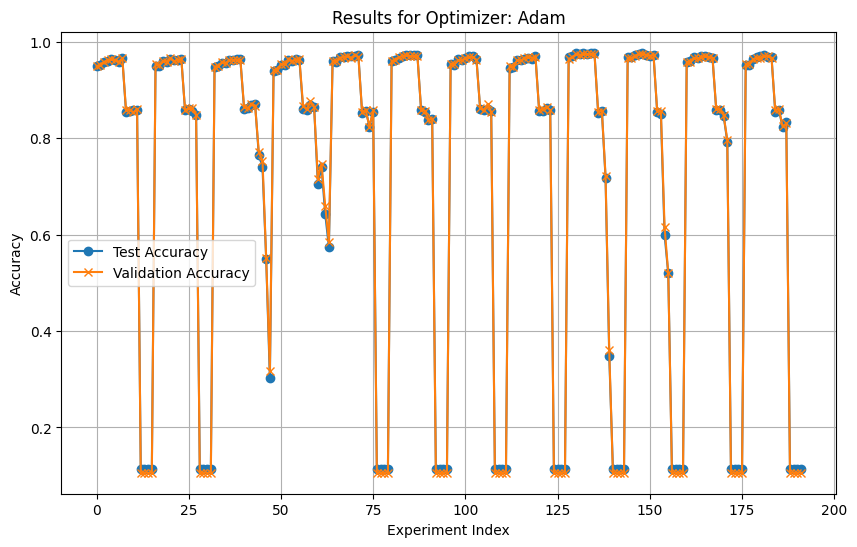

In [79]:
print("\nExecutando experimentos para o otimizador: Adam")
results_adam = run_experiments_for_optimizer(Adam, units_list, activations_list, dropout_rates, regularizers, num_dense_layers_list, losses)
print(analyze_results(results_adam))
plot_results(results_adam, 'Adam')
results_combined = pd.concat([results_combined, results_adam])


Executando experimentos para o otimizador: SGD


c:\Users\welli\anaconda3\envs\finaiti\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Units Activation  Dropout                                                           Regularizer  Num Dense Layers Optimizer                          Loss  Test Accuracy  Validation Accuracy
   256       relu      0.0                                                                  None                 6       SGD       CategoricalCrossentropy         0.9283             0.927667
   256       relu      0.2                                                                  None                 4       SGD SparseCategoricalCrossentropy         0.9273             0.925833
   256       relu      0.2                                                                  None                 6       SGD       CategoricalCrossentropy         0.9269             0.929083
   256       tanh      0.0                                                                  None                 6       SGD SparseCategoricalCrossentropy         0.9266             0.926833
   256       relu      0.0                   

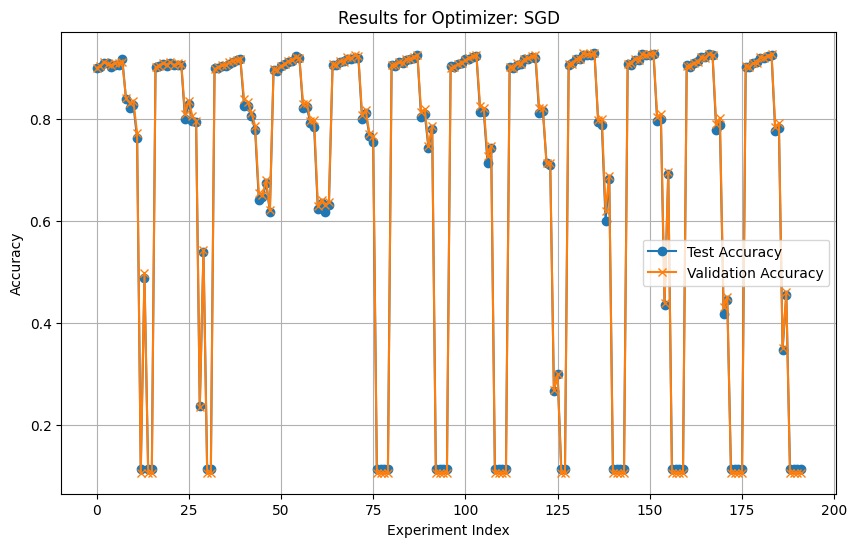

In [80]:
print("\nExecutando experimentos para o otimizador: SGD")
results_sgd = run_experiments_for_optimizer(SGD, units_list, activations_list, dropout_rates, regularizers, num_dense_layers_list, losses)
print(analyze_results(results_sgd))
plot_results(results_sgd, 'SGD')
results_combined = pd.concat([results_combined, results_sgd])


Executando experimentos para o otimizador: RMSprop


c:\Users\welli\anaconda3\envs\finaiti\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Units Activation  Dropout                                                           Regularizer  Num Dense Layers Optimizer                          Loss  Test Accuracy  Validation Accuracy
   256       relu      0.0                                                                  None                 2   RMSprop SparseCategoricalCrossentropy         0.9809             0.977083
   256       relu      0.0                                                                  None                 4   RMSprop SparseCategoricalCrossentropy         0.9798             0.976083
   256       relu      0.2                                                                  None                 2   RMSprop       CategoricalCrossentropy         0.9788             0.976417
   128       relu      0.2                                                                  None                 2   RMSprop       CategoricalCrossentropy         0.9779             0.975417
   256       relu      0.0                   

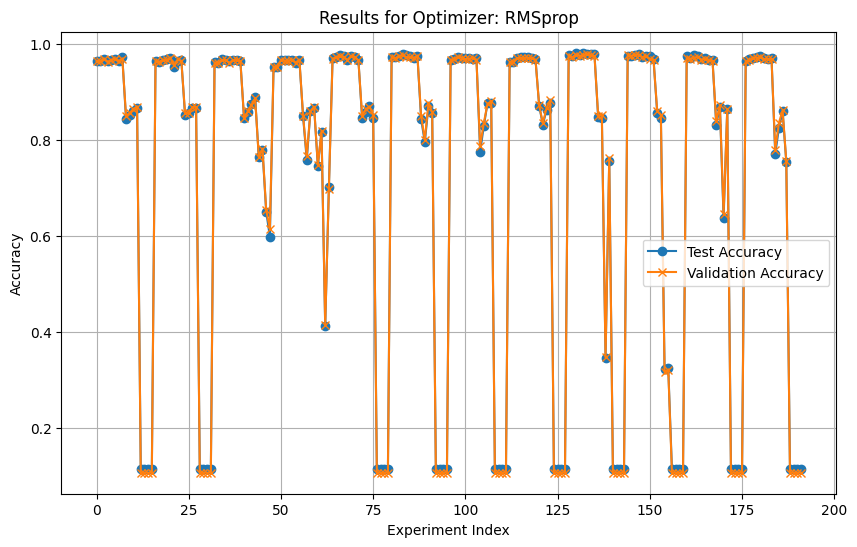

In [81]:
print("\nExecutando experimentos para o otimizador: RMSprop")
results_rmsprop = run_experiments_for_optimizer(RMSprop, units_list, activations_list, dropout_rates, regularizers, num_dense_layers_list, losses)
print(analyze_results(results_rmsprop))
plot_results(results_rmsprop, 'RMSprop')
results_combined = pd.concat([results_combined, results_rmsprop])


Comparando todos os otimizadores:


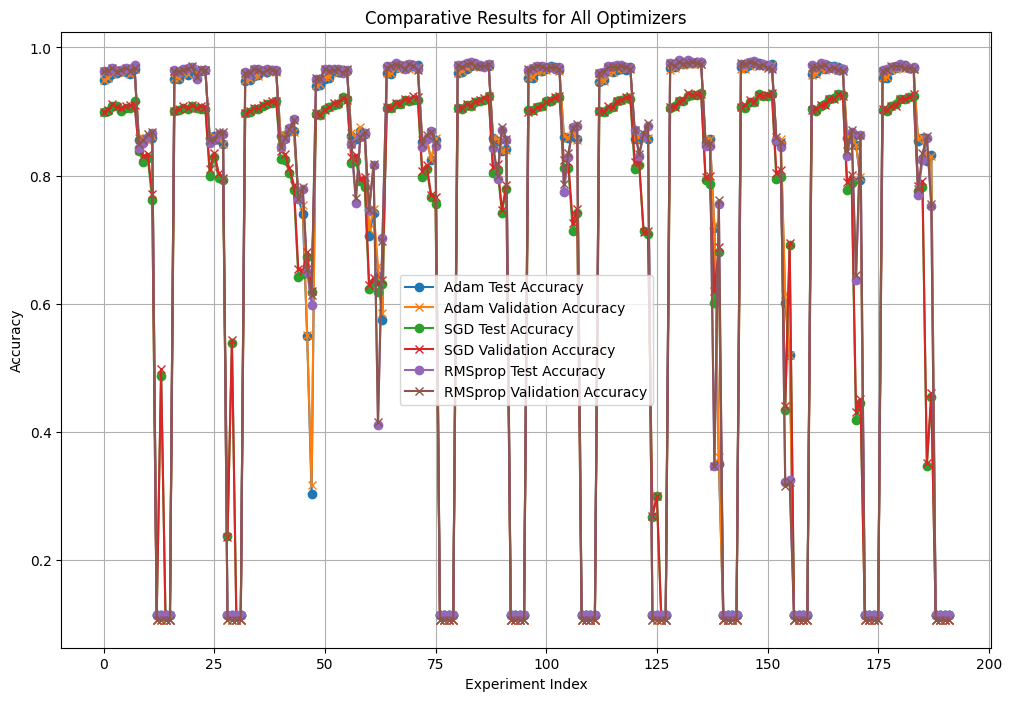

In [82]:
print("\nComparando todos os otimizadores:")
plot_combined_results(results_combined)

In [83]:
# Encontrar e exibir os melhores resultados para cada otimizador
best_results = find_best_results(results_combined)
print("\nMelhores resultados para cada otimizador:")
best_results


Melhores resultados para cada otimizador:


,Units,Activation,Dropout,Regularizer,Num Dense Layers,Optimizer,Loss,Test Accuracy,Validation Accuracy
130,256,relu,0.0,None,2,Adam,SparseCategoricalCrossentropy,0.9774,0.974167
130,256,relu,0.0,None,2,SGD,SparseCategoricalCrossentropy,0.9166,0.916583
130,256,relu,0.0,None,2,RMSprop,SparseCategoricalCrossentropy,0.9809,0.977083
130,256,relu,0.0,None,2,Adam,SparseCategoricalCrossentropy,0.9774,0.974167
130,256,relu,0.0,None,2,SGD,SparseCategoricalCrossentropy,0.9166,0.916583
130,256,relu,0.0,None,2,RMSprop,SparseCategoricalCrossentropy,0.9809,0.977083
135,256,relu,0.0,None,6,Adam,CategoricalCrossentropy,0.9772,0.974583
135,256,relu,0.0,None,6,SGD,CategoricalCrossentropy,0.9283,0.927667
135,256,relu,0.0,None,6,RMSprop,CategoricalCrossentropy,0.9776,0.974083
